# Mushroom Species Review

A machine-learning model for identifying edible and poisonous mushrooms!

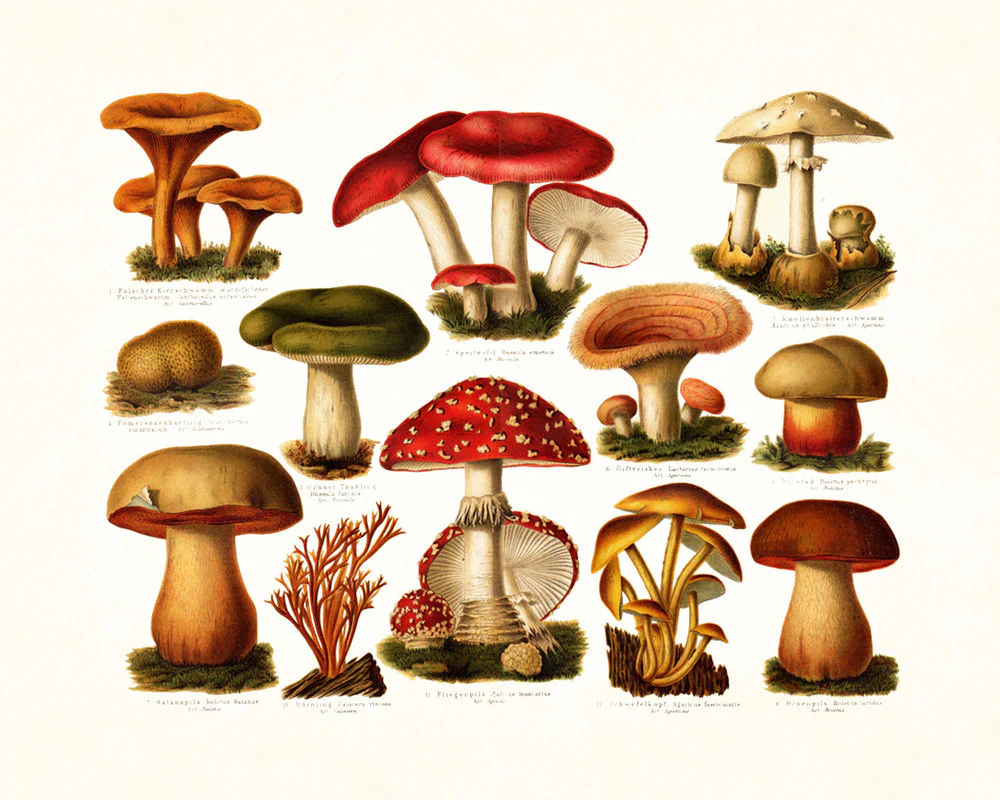

## Company Goals

NaturalistAI is looking to create a database, which can catalouge plants and mushrooms around the globe and categorize them based on their morphology. Depending on their characteristics, the NaturalistAI application will be able to identify weather a mushroom is either edible or poisonous, which can be utilized by users of the application who are looking to forage for wild mushrooms. 

The application will allow for users to enter in descriptors of the mushroom, which will then properly identify the species and edibility of the mushroom. Using information from the dataset, foragers will also know which habitats to explore for edible mushrooms, and which seasons are best for foraging.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import plot_roc_curve

from sklearn.model_selection import GridSearchCV

In [2]:
df_preview = pd.read_csv('mushroom_data/primary_data.csv', sep = ';')
df_main = pd.read_csv('mushroom_data/secondary_data.csv', sep = ';')
df_main = df_main.drop(columns = 'spore-print-color', axis = 1)

In [3]:
list(df_preview['name'].unique())[:20]

['Fly Agaric',
 'Panther Cap',
 'False Panther Cap',
 'The Blusher',
 'Death Cap',
 'False Death Cap',
 'Destroying Angel',
 'Tawny Grisette',
 'Parasol Mushroom',
 'Shaggy Parasol',
 'Stinking Parasol',
 'Saffron Parasol',
 'The Deceiver',
 'Amethyst Deceiver',
 'Wood Blewit',
 'Field Blewit',
 'Clouded Agaric',
 'Club-footed Funnel Cap',
 'Common Funnel Cap',
 'Aniseed Funnel Cap']

## Data Cleaning

This features of this dataset included many individual descriptors for the morphology of the mushroom. Some examples of these descriptors are cap veil type, cap surface, gill attachement, weather it bruises or bleeds, and the distinct colors of the mushroom. The target variable for this dataset was weather a mushroom was edible or poisonous.

The features of the dataset were not properly labelled, so the values within the features needed to be renamed so that they could be understood from an inferential perspective.

In [4]:
df_main = df_main.drop(['stem-root', 'stem-surface', 'veil-color', 
'veil-type', 'stem-surface', 'stem-root', 'gill-spacing'], axis = 1)

In [5]:
df_main = df_main.dropna(axis = 0, how= 'any', subset = ['ring-type', 'gill-attachment', 'cap-surface'])

In [6]:
cap_surface_dict = {'i': 'fibrous', 'g': 'grooves', 'y': 'scaly', 's': 'smooth',
'h': 'shiny', 'l': 'leathery', 'k': 'silky', 't': 'sticky', 'w': 'wrinkled', 'e': 'fleshy'}

In [7]:
df_main.loc[:,'cap-surface'] = df_main['cap-surface'].replace(cap_surface_dict)

In [8]:
df_main = df_main[df_main['cap-surface'] != 'd']

In [9]:
df_main['cap-surface'].value_counts()

sticky      7022
smooth      6559
shiny       3734
grooves     3665
scaly       3515
fleshy      1941
wrinkled    1797
silky       1636
fibrous     1519
leathery    1412
Name: cap-surface, dtype: int64

In [10]:
cap_shape_dict = {'b': 'bell', 'c': 'conical', 'x': 'convex', 'f': 'flat', 
's': 'sunken', 'p': 'spherical', 'o': 'others'}

In [11]:
df_main.loc[:,'cap-shape'] = df_main['cap-shape'].replace(cap_shape_dict)

In [12]:
df_main = df_main[df_main['cap-shape'] != 'others']

In [13]:
df_main['cap-shape'].value_counts()

convex       16071
flat          7465
sunken        3421
bell          2327
spherical     1287
conical       1002
Name: cap-shape, dtype: int64

In [14]:
cap_color_dict = {'n': 'brown', 'b': 'buff', 'g': 'gray', 'r': 'green', 'p': 'pink', 'u': 'purple', 'e': 'red', 
'w': 'white', 'y': 'yellow', 'l': 'blue', 'o': 'orange', 'k': 'black', 'f': 'none'}

In [15]:
df_main.loc[:,'cap-color'] = df_main['cap-color'].replace(cap_color_dict)

In [16]:
df_main['cap-color'].value_counts()

brown     13770
white      3933
yellow     3491
orange     2229
red        2118
gray       1491
pink       1219
black       944
green       837
purple      729
blue        554
buff        258
Name: cap-color, dtype: int64

In [17]:
bruise_dict = {'f': '0', 't': '1'}
df_main.loc[:,'does-bruise-or-bleed'] = df_main['does-bruise-or-bleed'].replace(bruise_dict)

In [18]:
df_main['does-bruise-or-bleed'].map(lambda x: float(x)).value_counts()

0.0    25572
1.0     6001
Name: does-bruise-or-bleed, dtype: int64

In [19]:
gill_attach_dict = {'a': 'adnate', 'x': 'adnexed', 'd': 'decurrent', 'e': 'free', 
's': 'sinuate', 'p': 'pores', 'f': 'none', '?': 'unknown'}

In [20]:
df_main.loc[:,'gill-attachment'] = df_main['gill-attachment'].replace(gill_attach_dict)

In [21]:
df_main = df_main[df_main['gill-attachment'] != 'none']

In [22]:
df_main['gill-attachment'].value_counts()

adnate       8848
decurrent    5362
free         4589
sinuate      4415
adnexed      4236
pores        3232
Name: gill-attachment, dtype: int64

In [23]:
df_main.loc[:,'gill-color'] = df_main['gill-color'].replace(cap_color_dict)

In [24]:
df_main.loc[:,'stem-color'] = df_main['stem-color'].replace(cap_color_dict)

In [25]:
df_main = df_main[df_main['gill-color'] != 'none']

In [26]:
df_main['gill-color'].value_counts()

white     9595
brown     6080
yellow    5018
pink      4290
gray      2008
orange    1497
black      690
red        602
green      387
purple     296
buff       219
Name: gill-color, dtype: int64

In [27]:
ring_dict = {'t': '1', 'f': '0'}
df_main.loc[:,'has-ring'] = df_main['has-ring'].replace(ring_dict)

In [28]:
df_main['has-ring'].map(lambda x: float(x)).value_counts()

0.0    22995
1.0     7687
Name: has-ring, dtype: int64

In [29]:
ring_type_dict = {'c': 'cobwebby', 'e': 'evanescent', 'r': 'flaring', 'g': 'grooved', 
'l': 'large', 'p': 'pendant', 's': 'sheathing', 'z': 'zone', 'y': 'scaly', 
'm': 'movable', 'f': 'none', '?': 'unknown'}

In [30]:
df_main.loc[:,'ring-type'] = df_main['ring-type'].replace(ring_type_dict)

In [31]:
df_main['ring-type'].value_counts()

none          23701
evanescent     1921
zone           1412
flaring        1320
pendant        1077
large          1074
grooved         177
Name: ring-type, dtype: int64

In [32]:
habitat_dict = {'g': 'grasses', 'l': 'leaves', 'm': 'meadows', 'p': 'paths', 'h': 'heaths',
'u': 'urban', 'w': 'waste', 'd': 'woods'}

In [33]:
df_main.loc[:,'habitat'] = df_main['habitat'].replace(habitat_dict)

In [34]:
df_main['habitat'].value_counts()

woods      20578
grasses     4117
meadows     2206
leaves      1785
heaths      1528
waste        353
urban        115
Name: habitat, dtype: int64

In [35]:
season_dict = {'s': 'spring', 'u': 'summer', 'a': 'autumn', 'w': 'winter'}

In [36]:
df_main.loc[:,'season'] = df_main['season'].replace(season_dict)

In [37]:
df_main['season'].value_counts()

autumn    15256
summer    11702
winter     2739
spring      985
Name: season, dtype: int64

###### Cleaning the target variable

In [38]:
df_main['class'].unique()

array(['p', 'e'], dtype=object)

In [39]:
class_dict = {'p': '0', 'e': '1'}

In [40]:
df_main.loc[:,'class'] = df_main['class'].replace(class_dict)

In [41]:
df_main['class'] = df_main['class'].map(lambda x: int(x))

##### Changing numerical values into floats

In [42]:
df_main['cap-diameter'] = df_main['cap-diameter'].map(lambda x: float(x))

In [43]:
df_main['does-bruise-or-bleed'] = df_main['does-bruise-or-bleed'].map(lambda x: float(x))

In [44]:
df_main['stem-height'] = df_main['stem-height'].map(lambda x: float(x))

In [45]:
df_main['stem-width'] = df_main['stem-width'].map(lambda x: float(x))

In [46]:
df_main['has-ring'] = df_main['has-ring'].map(lambda x: float(x))

##### Checking to make sure there are enough instances left and that the targets are balanced

In [47]:
df_main.shape

(30682, 15)

In [48]:
df_main['class'].value_counts(normalize=True)

0    0.549052
1    0.450948
Name: class, dtype: float64

## Data Exploration

Once the features were properly labelled, I was able to see, which features were correlated with each other and what the distribution of values were for each feature and the target variable.

In [49]:
df_main.head()

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-color,stem-height,stem-width,stem-color,has-ring,ring-type,habitat,season
0,0,15.26,convex,grooves,orange,0.0,free,white,16.95,17.09,white,1.0,grooved,woods,winter
1,0,16.60,convex,grooves,orange,0.0,free,white,17.99,18.19,white,1.0,grooved,woods,summer
2,0,14.07,convex,grooves,orange,0.0,free,white,17.80,17.74,white,1.0,grooved,woods,winter
3,0,14.17,flat,shiny,red,0.0,free,white,15.77,15.98,white,1.0,pendant,woods,winter
4,0,14.64,convex,shiny,orange,0.0,free,white,16.53,17.20,white,1.0,pendant,woods,winter


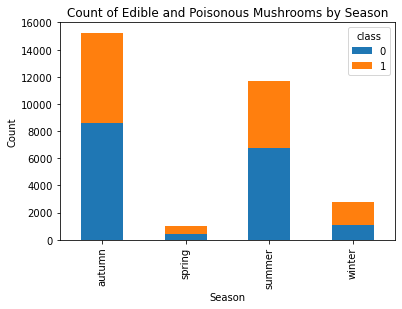

In [50]:
grouped = df_main.groupby(['season', 'class']).size().unstack(fill_value=0)
grouped.plot(kind='bar', stacked=True)

plt.xlabel('Season')
plt.ylabel('Count')
plt.title('Count of Edible and Poisonous Mushrooms by Season')
plt.show()

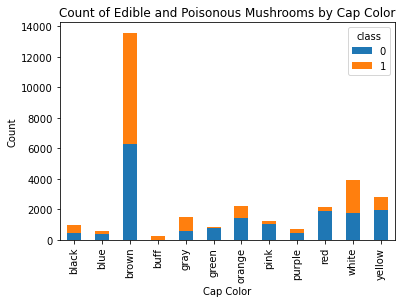

In [51]:
grouped = df_main.groupby(['cap-color', 'class']).size().unstack(fill_value=0)
grouped.plot(kind='bar', stacked=True)

plt.xlabel('Cap Color')
plt.ylabel('Count')
plt.title('Count of Edible and Poisonous Mushrooms by Cap Color')
plt.show()

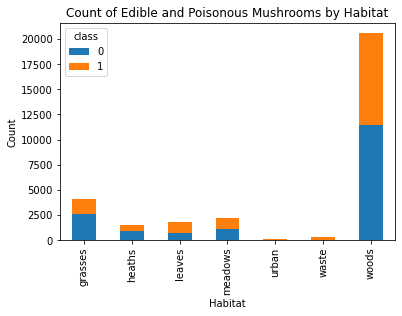

In [52]:
grouped = df_main.groupby(['habitat', 'class']).size().unstack(fill_value=0)
grouped.plot(kind='bar', stacked=True)

plt.xlabel('Habitat')
plt.ylabel('Count')
plt.title('Count of Edible and Poisonous Mushrooms by Habitat')
plt.show()

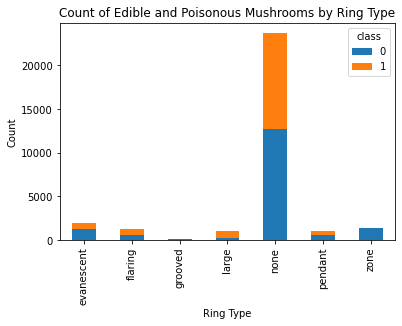

In [53]:
grouped = df_main.groupby(['ring-type', 'class']).size().unstack(fill_value=0)
grouped.plot(kind='bar', stacked=True)

plt.xlabel('Ring Type')
plt.ylabel('Count')
plt.title('Count of Edible and Poisonous Mushrooms by Ring Type')
plt.show()

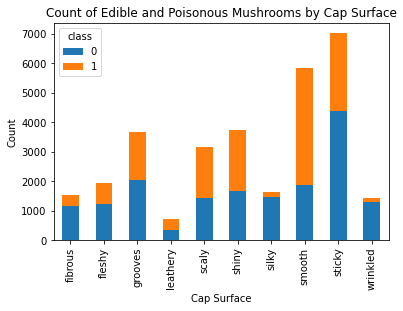

In [54]:
grouped = df_main.groupby(['cap-surface', 'class']).size().unstack(fill_value=0)
grouped.plot(kind='bar', stacked=True)

plt.xlabel('Cap Surface')
plt.ylabel('Count')
plt.title('Count of Edible and Poisonous Mushrooms by Cap Surface')
plt.show()

In these bar graphs we can see that there is a 

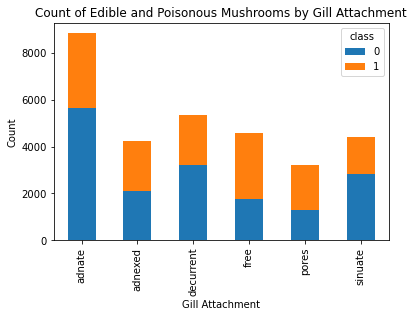

In [55]:
grouped = df_main.groupby(['gill-attachment', 'class']).size().unstack(fill_value=0)
grouped.plot(kind='bar', stacked=True)

plt.xlabel('Gill Attachment')
plt.ylabel('Count')
plt.title('Count of Edible and Poisonous Mushrooms by Gill Attachment')
plt.show()

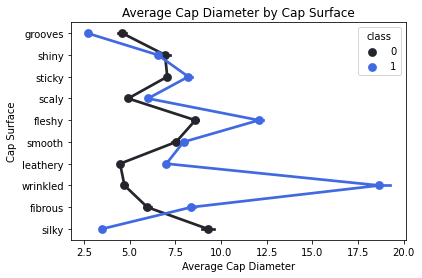

In [56]:
sns.pointplot(x=df_main['cap-diameter'], y=df_main['cap-surface'], data=df_main, hue=df_main['class'], color = "royalblue")

plt.xlabel("Average Cap Diameter")
plt.ylabel("Cap Surface")
plt.title("Average Cap Diameter by Cap Surface")
plt.show()

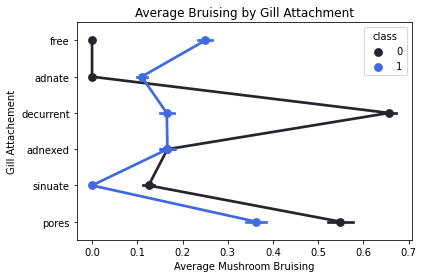

In [57]:
sns.pointplot(x=df_main['does-bruise-or-bleed'], y=df_main['gill-attachment'], data=df_main, hue=df_main['class'], color = "royalblue")

plt.xlabel("Average Mushroom Bruising")
plt.ylabel("Gill Attachement")
plt.title("Average Bruising by Gill Attachment")
plt.show()

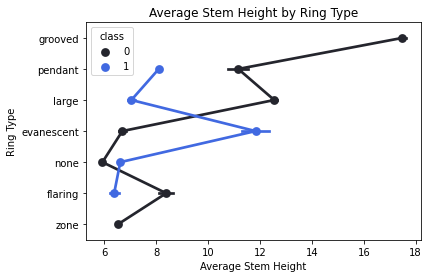

In [58]:
sns.pointplot(x=df_main['stem-height'], y=df_main['ring-type'], data=df_main, hue=df_main['class'], color = "royalblue")

plt.xlabel("Average Stem Height")
plt.ylabel("Ring Type")
plt.title("Average Stem Height by Ring Type")
plt.show()

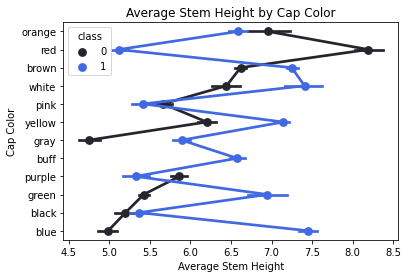

In [59]:
sns.pointplot(x=df_main['stem-height'], y=df_main['cap-color'], data=df_main, hue=df_main['class'], color = "royalblue")

plt.xlabel("Average Stem Height")
plt.ylabel("Cap Color")
plt.title("Average Stem Height by Cap Color")
plt.show()

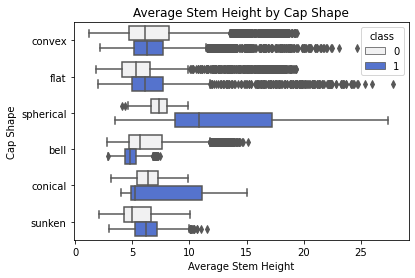

In [60]:
sns.boxplot(x=df_main['stem-height'], y=df_main['cap-shape'], data=df_main, hue=df_main['class'], color = "royalblue")

plt.xlabel("Average Stem Height")
plt.ylabel("Cap Shape")
plt.title("Average Stem Height by Cap Shape")
plt.show()

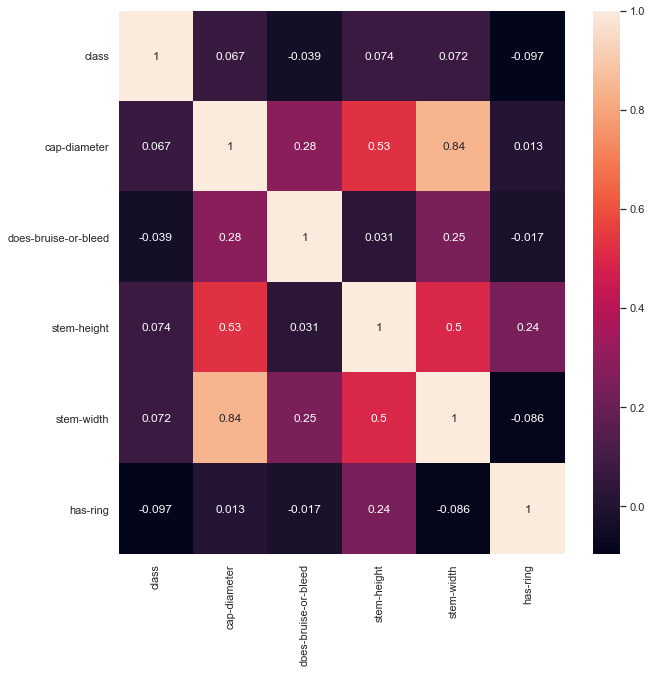

In [61]:
sns.set(rc={'figure.figsize':(10, 10)})
sns.heatmap(df_main.corr(),annot=True);

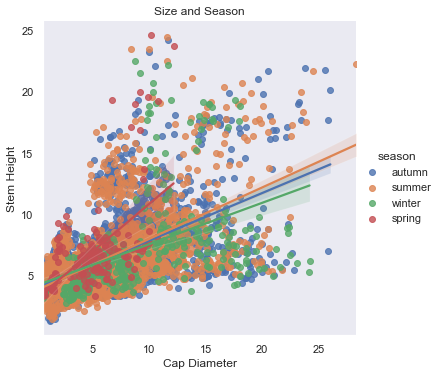

In [62]:
sns.lmplot(x='cap-diameter', y='stem-height', hue='season', data=df_main.sample(n=5000, random_state=42))
# sns.scatterplot(x='cap-diameter', y='stem-height', hue='season', data=df_main.sample(n=5000, random_state=42))

plt.xlabel('Cap Diameter')
plt.ylabel('Stem Height')
plt.title('Size and Season')
plt.grid(False)
plt.show()

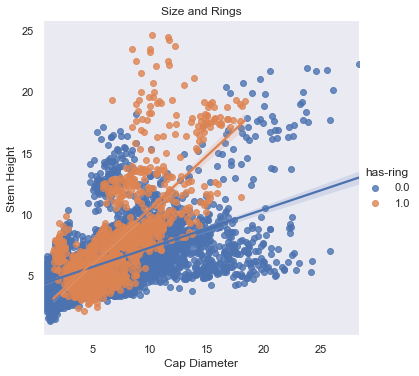

In [63]:
sns.lmplot(x='cap-diameter', y='stem-height', hue='has-ring', data=df_main.sample(n=5000, random_state=42))
# sns.scatterplot(x='cap-diameter', y='stem-height', hue='has-ring', data=df_main.sample(n=5000, random_state=42))

plt.xlabel('Cap Diameter')
plt.ylabel('Stem Height')
plt.title('Size and Rings')
plt.grid(False)
plt.show()

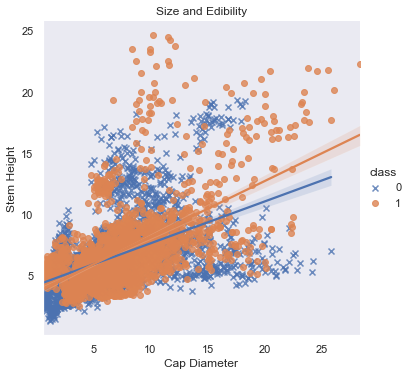

In [64]:
sns.lmplot(x='cap-diameter', y='stem-height', hue='class', data=df_main.sample(n=5000, random_state=42), markers=["x", "o"])
# sns.scatterplot(x='cap-diameter', y='stem-height', hue='class', data=df_main.sample(n=1000, random_state=42))

plt.xlabel('Cap Diameter')
plt.ylabel('Stem Height')
plt.title('Size and Edibility')
plt.grid(False)
plt.show()


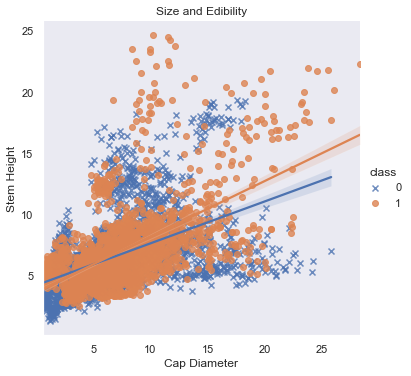

In [65]:
sns.lmplot(x='cap-diameter', y='stem-height', hue='class', data=df_main.sample(n=5000, random_state=42), markers=["x", "o"])
# sns.scatterplot(x='cap-diameter', y='stem-height', hue='class', data=df_main.sample(n=1000, random_state=42))

plt.xlabel('Cap Diameter')
plt.ylabel('Stem Height')
plt.title('Size and Edibility')
plt.grid(False)
plt.show()


## First Model - Logistic Regression

Here I am separating and concatenating the categoricals and numericals within the dataset, before I fit my base logistic regression model.

In [66]:
object_columns = df_main.columns[df_main.dtypes == 'object']
categoricals = df_main[object_columns].copy()
categoricals.head()

,cap-shape,cap-surface,cap-color,gill-attachment,gill-color,stem-color,ring-type,habitat,season
0,convex,grooves,orange,free,white,white,grooved,woods,winter
1,convex,grooves,orange,free,white,white,grooved,woods,summer
2,convex,grooves,orange,free,white,white,grooved,woods,winter
3,flat,shiny,red,free,white,white,pendant,woods,winter
4,convex,shiny,orange,free,white,white,pendant,woods,winter


In [67]:
numerical_columns = df_main.columns[df_main.dtypes == 'float64']
numericals = df_main[numerical_columns].copy()
numericals.head()

,cap-diameter,does-bruise-or-bleed,stem-height,stem-width,has-ring
0,15.26,0.0,16.95,17.09,1.0
1,16.60,0.0,17.99,18.19,1.0
2,14.07,0.0,17.80,17.74,1.0
3,14.17,0.0,15.77,15.98,1.0
4,14.64,0.0,16.53,17.20,1.0


In [68]:
ohe = OneHotEncoder(drop = 'first', sparse = False)

ohe.fit(categoricals)
one_hot_encoded = ohe.transform(categoricals)

In [69]:
df_ohe = pd.DataFrame(one_hot_encoded, columns=ohe.get_feature_names(categoricals.columns))

In [70]:
df_ohe

,cap-shape_conical,cap-shape_convex,cap-shape_flat,cap-shape_spherical,cap-shape_sunken,cap-surface_fleshy,cap-surface_grooves,cap-surface_leathery,cap-surface_scaly,cap-surface_shiny,...,ring-type_zone,habitat_heaths,habitat_leaves,habitat_meadows,habitat_urban,habitat_waste,habitat_woods,season_spring,season_summer,season_winter
0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30677,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
30678,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
30679,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
30680,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [71]:
concat = pd.concat([df_ohe, numericals, df_main['class']], axis=1)
concat_df = concat.dropna()

In [72]:
concat_df.shape

(18091, 71)

### Fitting The Model

In [73]:
X = concat_df.drop('class', axis = 1)
y = concat_df['class']

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [75]:
ss = StandardScaler()

X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

In [76]:
X_train_scaled = pd.DataFrame(X_train_scaled, index = X_train.index, columns = X_train.columns)

In [77]:
logit = LogisticRegression(max_iter=5000, random_state=53)
logit.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=5000, random_state=53)

In [78]:
y_test_predict = logit.predict(X_test_scaled)

In [79]:
accuracy = accuracy_score(y_test, y_test_predict)
precision = precision_score(y_test, y_test_predict)
recall = recall_score(y_test, y_test_predict)
f1 = f1_score(y_test, y_test_predict)
roc_auc = roc_auc_score(y_test, y_test_predict)
conf_matrix = confusion_matrix(y_test, y_test_predict)

In [80]:
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)

Accuracy: 0.8458987397744859
Precision: 0.8381120423467138
Recall: 0.852017937219731
F1 Score: 0.8450077829664222
ROC AUC Score: 0.8459828020158838


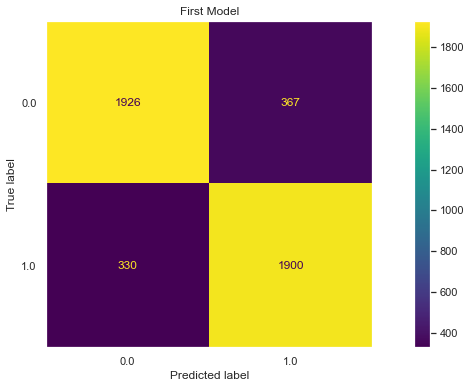

In [81]:
fix, ax = plt.subplots(figsize=(15, 6))

ax.set_title("First Model")
plot_confusion_matrix(logit, X_test_scaled, y_test, ax=ax, cmap="viridis");
plt.grid(False)

The model is running at 0.84 accuracy and 0.84 precision, which is good for the base model. Here we are looking to increase precision, since the classification is for poisonous mushrooms, which means we want more bias towards false negatives than false positives.

## Second Model - Selecting Features

In order to improve our second model we are going to get rid of fesatures with a high variance inflation factor which accounts for multicolinearity.

In [82]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif = vif.sort_values('VIF Factor', ascending=False)

In [83]:
vif.head(10)

,VIF Factor,features
53,38.682103,ring-type_none
41,36.226584,stem-color_brown
48,34.155686,stem-color_white
65,29.112492,cap-diameter
38,24.198942,gill-color_white
68,23.922407,stem-width
15,20.946176,cap-color_brown
67,16.372439,stem-height
30,14.748832,gill-color_brown
1,13.566696,cap-shape_convex


In [84]:
best_vals = vif[vif['VIF Factor'] < 5] 
best_vals.shape

(44, 2)

In [85]:
new_cats = best_vals['features'].values

In [86]:
df_new = concat_df[new_cats]

In [87]:
df_select = pd.concat([df_new, numericals, df_main['class']], axis=1)
df_select = df_select.dropna()

In [88]:
df_select.head()

,cap-surface_scaly,stem-color_red,gill-attachment_free,gill-color_gray,cap-surface_silky,gill-color_orange,cap-shape_sunken,cap-surface_fleshy,ring-type_pendant,does-bruise-or-bleed,...,stem-color_blue,season_spring,gill-color_purple,habitat_urban,cap-diameter,does-bruise-or-bleed,stem-height,stem-width,has-ring,class
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,15.26,0.0,16.95,17.09,1.0,0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,16.60,0.0,17.99,18.19,1.0,0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,14.07,0.0,17.80,17.74,1.0,0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,14.17,0.0,15.77,15.98,1.0,0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,14.64,0.0,16.53,17.20,1.0,0


### Fitting The Model

In [89]:
X_sel = df_select.drop('class', axis = 1)
y_sel = df_select['class']

In [90]:
X_train_sel, X_test_sel, y_train_sel, y_test_sel = train_test_split(X_sel, y_sel, test_size = 0.25, random_state = 44)

In [91]:
ss_sel = StandardScaler()

X_train_sel = ss_sel.fit_transform(X_train_sel)
X_test_sel = ss_sel.transform(X_test_sel)

In [92]:
logreg_select = LogisticRegression(max_iter=10000, solver = 'lbfgs', random_state=77)
logreg_select.fit(X_train_sel, y_train_sel)

LogisticRegression(max_iter=10000, random_state=77)

In [93]:
y_sel_pred = logreg_select.predict(X_test_sel)

In [94]:
accuracy = accuracy_score(y_test_sel, y_sel_pred)
precision = precision_score(y_test_sel, y_sel_pred)
recall = recall_score(y_test_sel, y_sel_pred)
f1 = f1_score(y_test_sel, y_sel_pred)
roc_auc = roc_auc_score(y_test_sel, y_sel_pred)
conf_matrix = confusion_matrix(y_test_sel, y_sel_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)

Accuracy: 0.7422065001105461
Precision: 0.7423759672280382
Recall: 0.7310623038995966
F1 Score: 0.7366757000903342
ROC AUC Score: 0.7420582025606186


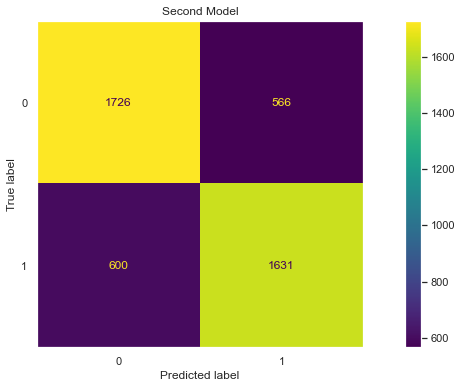

In [95]:
fix, ax = plt.subplots(figsize=(15, 6))

ax.set_title("Second Model")
plot_confusion_matrix(logreg_select, X_test_sel, y_test_sel, ax=ax, cmap="viridis");
plt.grid(False)

Unsurprisingly, getting rid of the Multicolinear features made our model perform worse than the last model, although this model is still doing well.

## Cross-Validate Models

In [96]:
logreg_model_results = cross_val_score(logit, X_train_scaled, y_train, cv=10, scoring='precision')
logreg_selector_results = cross_val_score(logreg_select, X_train_sel, y_train_sel, cv=10, scoring='precision')

In [97]:
model_results_mean = np.mean(logreg_model_results)
selector_results_mean = np.mean(logreg_selector_results)

model_results_std = np.std(logreg_model_results)
selector_results_std = np.std(logreg_selector_results)

print(f'Precision for base model is: {model_results_mean} ± {round(model_results_std, 2)}')
print(f'Precision for this base model with selected features is: \
{selector_results_mean} ± {round(selector_results_std, 2)}')

Precision for base model is: 0.8480546712619457 ± 0.01
Precision for this base model with selected features is: 0.7446083011954686 ± 0.01


<AxesSubplot:title={'center':'CV Results for Base Model'}>

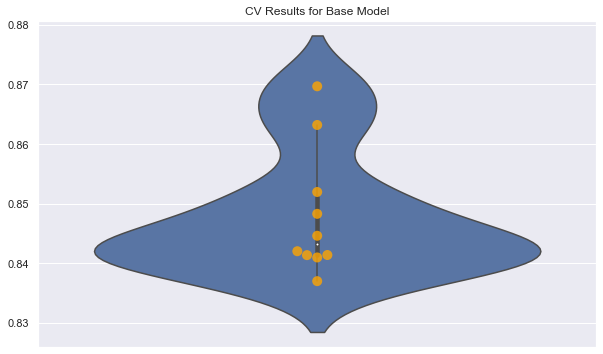

In [98]:
f, ax = plt.subplots(figsize=(10, 6))
ax.set_title(f'CV Results for Base Model')

sns.violinplot(y=logreg_model_results, ax=ax, bw=.4)
sns.swarmplot(y=logreg_model_results, color='orange', size=10, alpha= 0.8, ax=ax)

<AxesSubplot:title={'center':'CV Results for Base Model with Selected Features'}>

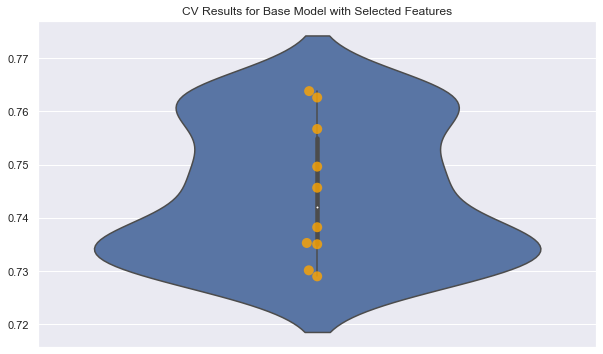

In [99]:
f, axes = plt.subplots(figsize=(10, 6))
axes.set_title(f'CV Results for Base Model with Selected Features')

sns.violinplot(y=logreg_selector_results, ax=axes, bw=.4)
sns.swarmplot(y=logreg_selector_results, color='orange', size=10, alpha= 0.8, ax=axes)

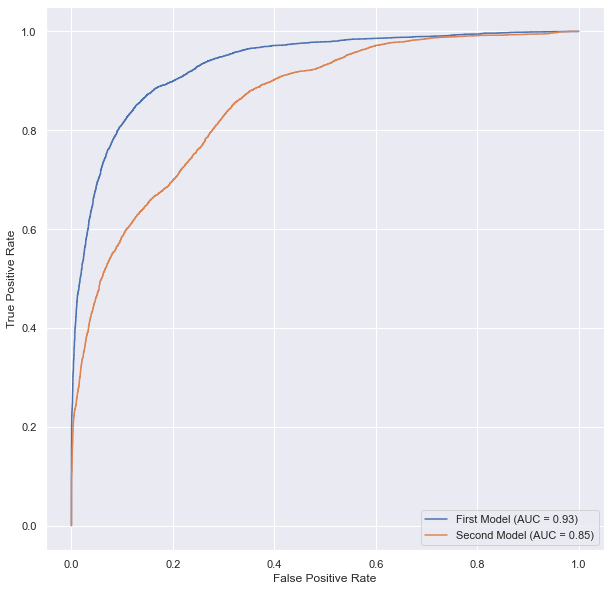

In [100]:
fig, ax = plt.subplots()

plot_roc_curve(logit, X_train_scaled, y_train, name='First Model', ax=ax)
plot_roc_curve(logreg_select, X_train_sel, y_train_sel, name='Second Model', ax=ax);

## Model 3 - Decision Tree Classifier

In [101]:
dt = DecisionTreeClassifier(criterion = 'gini', random_state = 42)
dt.fit(X_train_scaled, y_train)

DecisionTreeClassifier(random_state=42)

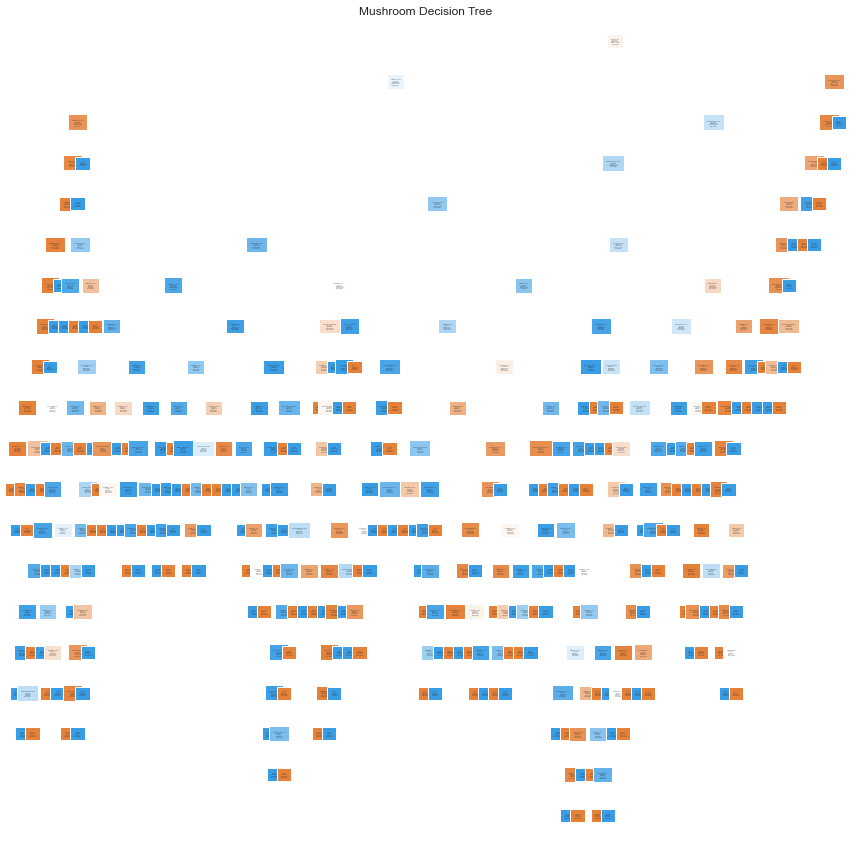

In [102]:
f, ax = plt.subplots(figsize=(15, 15))

plot_tree(dt, ax=ax, filled=True, feature_names=X_train.columns, class_names=['Class 0', 'Class 1'], fontsize=0.1)
ax.set_title("Mushroom Decision Tree")
plt.show()

In [103]:
relevant_indices = np.where(sorted(dt.feature_importances_, reverse = True))
relevant_columns = X_train_scaled.columns[relevant_indices]

list(relevant_columns[0:30])

['cap-shape_conical',
 'cap-shape_convex',
 'cap-shape_flat',
 'cap-shape_spherical',
 'cap-shape_sunken',
 'cap-surface_fleshy',
 'cap-surface_grooves',
 'cap-surface_leathery',
 'cap-surface_scaly',
 'cap-surface_shiny',
 'cap-surface_silky',
 'cap-surface_smooth',
 'cap-surface_sticky',
 'cap-surface_wrinkled',
 'cap-color_blue',
 'cap-color_brown',
 'cap-color_buff',
 'cap-color_gray',
 'cap-color_green',
 'cap-color_orange',
 'cap-color_pink',
 'cap-color_purple',
 'cap-color_red',
 'cap-color_white',
 'cap-color_yellow',
 'gill-attachment_adnexed',
 'gill-attachment_decurrent',
 'gill-attachment_free',
 'gill-attachment_pores',
 'gill-attachment_sinuate']

In [104]:
dt_model_results = cross_val_score(dt, X_train_scaled, y_train, cv=10, scoring='precision')

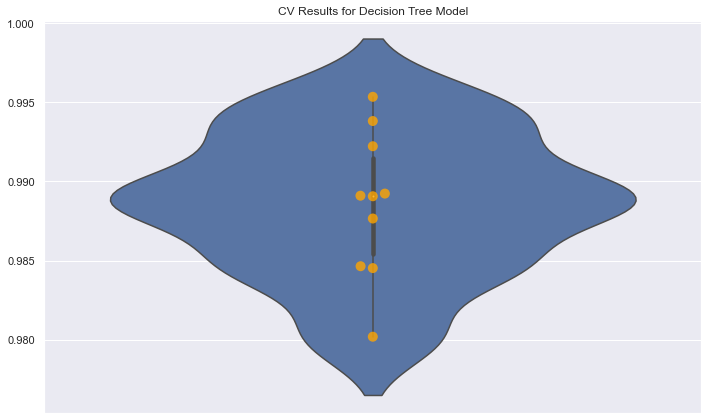

In [105]:
f, axes = plt.subplots(figsize=(10, 6))
axes.set_title(f'CV Results for Decision Tree Model')

sns.violinplot(y=dt_model_results, ax=axes, bw=.4)
sns.swarmplot(y=dt_model_results, color='orange', size=10, alpha= 0.8, ax=axes)
plt.tight_layout();

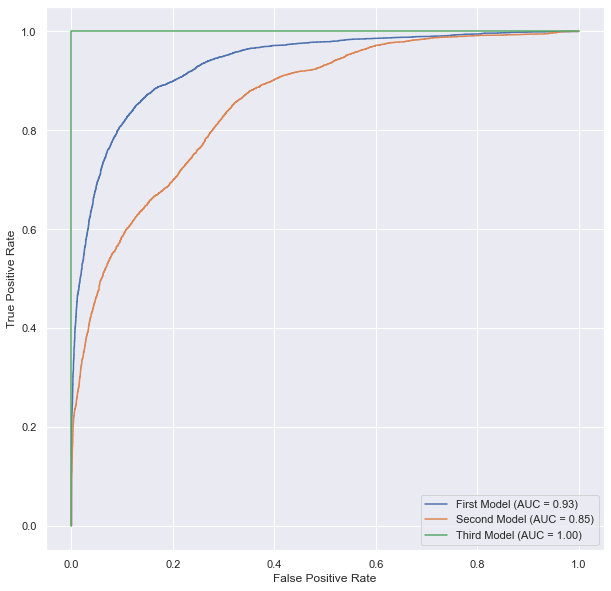

In [106]:
fig, ax = plt.subplots()

plot_roc_curve(logit, X_train_scaled, y_train, name='First Model', ax=ax)
plot_roc_curve(logreg_select, X_train_sel, y_train_sel, name='Second Model', ax=ax);
plot_roc_curve(dt, X_train_scaled, y_train, name='Third Model', ax=ax);

## Model Hyper-Parameter Tuner

In [107]:
class ModelHyperparameterTuner:
    
    def __init__(self, cv=5):

        self.cv = cv
        self.best_models = {}
        
        # Define parameter grids for logistic regression and decision tree models
        self.logistic_regression_param_grid = {
            'penalty': ['l1', 'l2', 'elasticnet'],
            'C': [0.1, 1, 10, 100],
            'solver': ['liblinear', 'lbfgs'],
            'max_iter': [100, 500, 1000],
        }
        
        self.decision_tree_param_grid = {
            'criterion': ['gini', 'entropy'],
            'max_depth': [3, 5, 10, 20]
        }

    def tune_model(self, model_type, estimator, param_grid, X, y):
        
        grid_search = GridSearchCV(estimator, param_grid, cv=self.cv, scoring='precision')
        grid_search.fit(X, y)

        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_
        best_score = grid_search.best_score_

        return best_params, best_score, best_model

    def tune_logistic_regression(self, X, y):
        
        ss = StandardScaler()
        ss.fit(X)
        X_scaled = ss.transform(X)

        best_model, best_params, best_score = self.tune_model(
            'logistic_regression', LogisticRegression(), self.logistic_regression_param_grid, X_scaled, y)

        self.best_models['lr'] = {
            'model': best_model,
            'params': best_params,
            'best_score': best_score
        }

    def tune_decision_tree(self, X, y):
        
        ss = StandardScaler()
        ss.fit(X)
        X_scaled = ss.transform(X)
       
        best_model, best_params, best_score = self.tune_model(
            'decision_tree', DecisionTreeClassifier(), self.decision_tree_param_grid, X_scaled, y)

        self.best_models['dt'] = {
            'model': best_model,
            'params': best_params,
            'best_score': best_score
        }


In [108]:
tuner = ModelHyperparameterTuner()
tuner.tune_logistic_regression(X_train, y_train)

/Users/jacobserfaty/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacobserfaty/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jacobserfaty/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/jacobserfaty/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  

/Users/jacobserfaty/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacobserfaty/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jacobserfaty/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/jacobserfaty/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  

/Users/jacobserfaty/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacobserfaty/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jacobserfaty/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/jacobserfaty/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  

/Users/jacobserfaty/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacobserfaty/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jacobserfaty/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/jacobserfaty/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  

/Users/jacobserfaty/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/jacobserfaty/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lear

In [109]:
tuner.tune_decision_tree(X_train, y_train)

In [110]:
best_lr_model = tuner.best_models['lr']['model']
best_lr_params = tuner.best_models['lr']['params']
best_lr_score = tuner.best_models['lr']['best_score']

best_dt_model = tuner.best_models['dt']['model']
best_dt_params = tuner.best_models['dt']['params'] 
best_dt_score = tuner.best_models['dt']['best_score']

In [111]:
print(best_lr_model, '\n')
print(best_lr_params, '\n')
print(best_lr_score, '\n')

{'C': 1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'} 

0.8466674802950223 

LogisticRegression(C=1, solver='liblinear') 



In [112]:
print(best_dt_model, '\n')
print(best_dt_params, '\n')
print(best_dt_score, '\n')

{'criterion': 'gini', 'max_depth': 20} 

0.989177033928445 

DecisionTreeClassifier(max_depth=20) 



In [113]:
tuner_sel = ModelHyperparameterTuner()
tuner_sel.tune_logistic_regression(X_train_sel, y_train_sel)

/Users/jacobserfaty/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacobserfaty/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jacobserfaty/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/jacobserfaty/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  

/Users/jacobserfaty/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacobserfaty/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jacobserfaty/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/jacobserfaty/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  

/Users/jacobserfaty/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacobserfaty/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jacobserfaty/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/jacobserfaty/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  

/Users/jacobserfaty/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacobserfaty/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jacobserfaty/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/jacobserfaty/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  

In [114]:
tuner_sel.tune_decision_tree(X_train_sel, y_train_sel)

In [115]:
sel_lr_model = tuner_sel.best_models['lr']['model']
sel_lr_params = tuner_sel.best_models['lr']['params']
sel_lr_score = tuner_sel.best_models['lr']['best_score']

sel_dt_model = tuner_sel.best_models['dt']['model']
sel_dt_params = tuner_sel.best_models['dt']['params']
sel_dt_score = tuner_sel.best_models['dt']['best_score']

In [116]:
print(sel_lr_model, '\n')
print(sel_lr_params, '\n')
print(sel_lr_score, '\n')

{'C': 10, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'} 

0.7448693624369419 

LogisticRegression(C=10, solver='liblinear') 



In [117]:
print(sel_dt_model, '\n')
print(sel_dt_params, '\n')
print(sel_dt_score, '\n')

{'criterion': 'entropy', 'max_depth': 20} 

0.9766785082786373 

DecisionTreeClassifier(criterion='entropy', max_depth=20) 



## Final Model - Decision Tree

In [118]:
dt_final = DecisionTreeClassifier(criterion='gini', max_depth=20, random_state=42)

In [119]:
dt_final.fit(X_train_scaled, y_train)

DecisionTreeClassifier(max_depth=20, random_state=42)

In [120]:
y_pred_final = dt_final.predict(X_test_scaled)

In [121]:
final_precision = precision_score(y_pred_final, y_test)
final_precision

0.9937219730941704

In [122]:
dt_final_results = cross_val_score(dt_final, X_train_scaled, y_train, cv=10, scoring='precision')

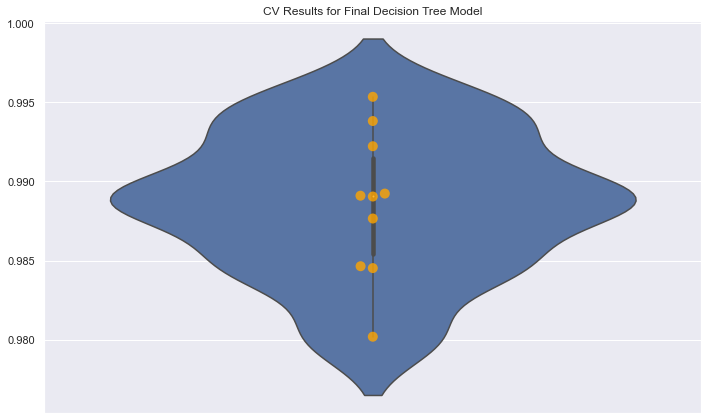

In [123]:
f, axes = plt.subplots(figsize=(10, 6))
axes.set_title(f'CV Results for Final Decision Tree Model')

sns.violinplot(y=dt_final_results, ax=axes, bw=.4)
sns.swarmplot(y=dt_final_results, color='orange', size=10, alpha= 0.8, ax=axes)
plt.tight_layout();

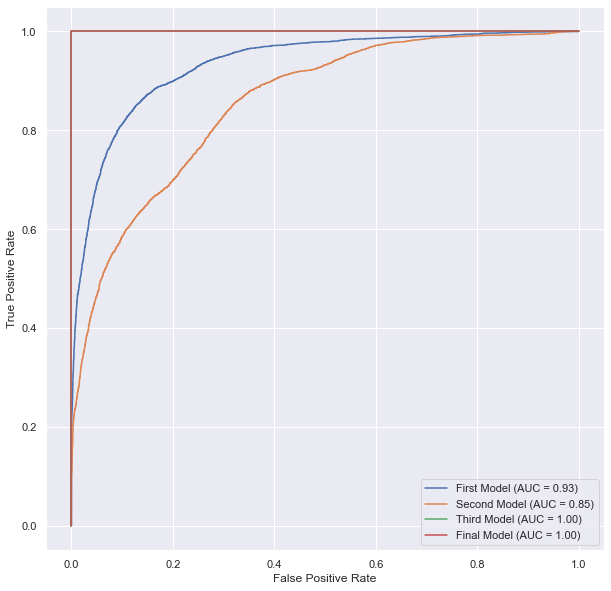

In [124]:
fig, ax = plt.subplots()

plot_roc_curve(logit, X_train_scaled, y_train, name='First Model', ax=ax)
plot_roc_curve(logreg_select, X_train_sel, y_train_sel, name='Second Model', ax=ax);
plot_roc_curve(dt, X_train_scaled, y_train, name='Third Model', ax=ax);
plot_roc_curve(dt_final, X_train_scaled, y_train, name='Final Model', ax=ax);

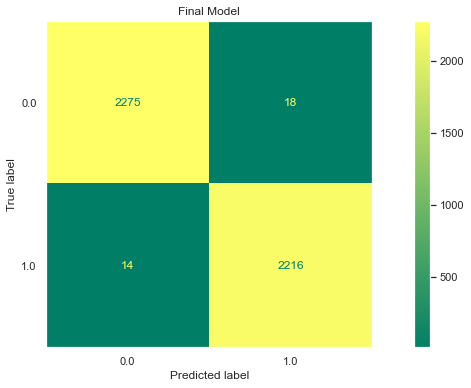

In [125]:
fix, ax = plt.subplots(figsize=(15, 6))

ax.set_title("Final Model")
plot_confusion_matrix(dt_final, X_test_scaled, y_test, ax=ax, cmap="summer");
plt.grid(False)

In [126]:
final_relevant_indices = np.where(sorted(dt_final.feature_importances_, reverse = True))
final_relevant_columns = X_train_scaled.columns[final_relevant_indices]

list(final_relevant_columns[0:30])

['cap-shape_conical',
 'cap-shape_convex',
 'cap-shape_flat',
 'cap-shape_spherical',
 'cap-shape_sunken',
 'cap-surface_fleshy',
 'cap-surface_grooves',
 'cap-surface_leathery',
 'cap-surface_scaly',
 'cap-surface_shiny',
 'cap-surface_silky',
 'cap-surface_smooth',
 'cap-surface_sticky',
 'cap-surface_wrinkled',
 'cap-color_blue',
 'cap-color_brown',
 'cap-color_buff',
 'cap-color_gray',
 'cap-color_green',
 'cap-color_orange',
 'cap-color_pink',
 'cap-color_purple',
 'cap-color_red',
 'cap-color_white',
 'cap-color_yellow',
 'gill-attachment_adnexed',
 'gill-attachment_decurrent',
 'gill-attachment_free',
 'gill-attachment_pores',
 'gill-attachment_sinuate']

## Final Model with Selected Features - Decision Tree

In [127]:
dt_final_sel = DecisionTreeClassifier(criterion='gini', max_depth=20, random_state=2002)

In [128]:
dt_final_sel.fit(X_train_sel, y_train_sel)

DecisionTreeClassifier(max_depth=20, random_state=2002)

In [129]:
y_sel_predict = dt_final_sel.predict(X_test_sel)

In [130]:
final_precision_sel = precision_score(y_test_sel, y_sel_predict)
final_precision_sel

0.9762118491921006

In [131]:
dt_final_sel_results = cross_val_score(dt_final_sel, X_train_sel, y_train_sel, cv=10, scoring='precision')

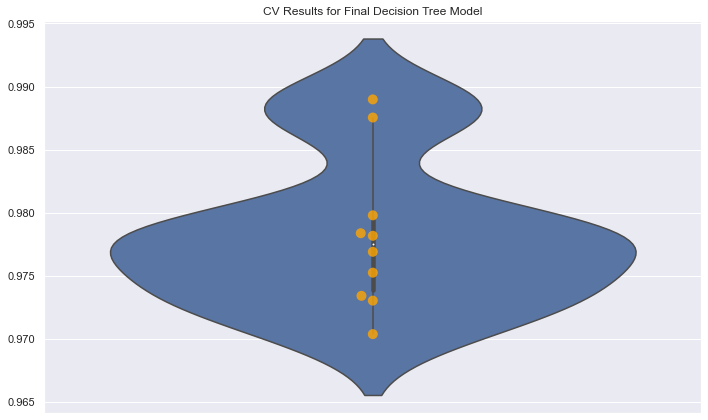

In [132]:
f, axes = plt.subplots(figsize=(10, 6))
axes.set_title(f'CV Results for Final Decision Tree Model')

sns.violinplot(y=dt_final_sel_results, ax=axes, bw=.4)
sns.swarmplot(y=dt_final_sel_results, color='orange', size=10, alpha= 0.8, ax=axes)
plt.tight_layout();

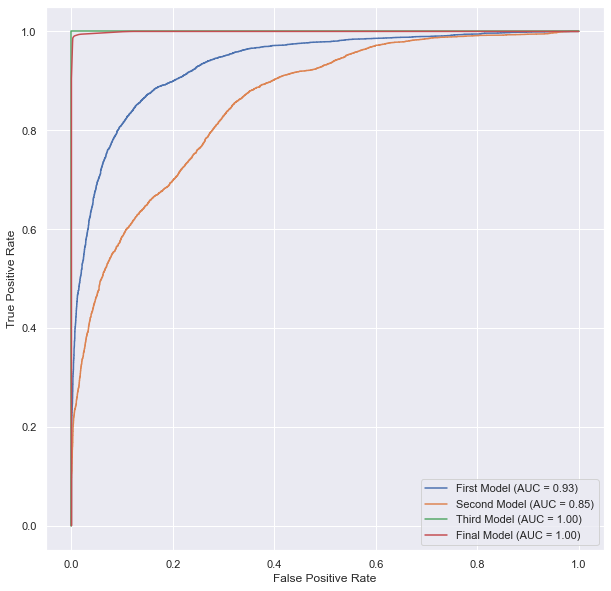

In [133]:
fig, ax = plt.subplots()

plot_roc_curve(logit, X_train_scaled, y_train, name='First Model', ax=ax)
plot_roc_curve(logreg_select, X_train_sel, y_train_sel, name='Second Model', ax=ax);
plot_roc_curve(dt, X_train_scaled, y_train, name='Third Model', ax=ax);
plot_roc_curve(dt_final_sel, X_train_sel, y_train_sel, name='Final Model', ax=ax);

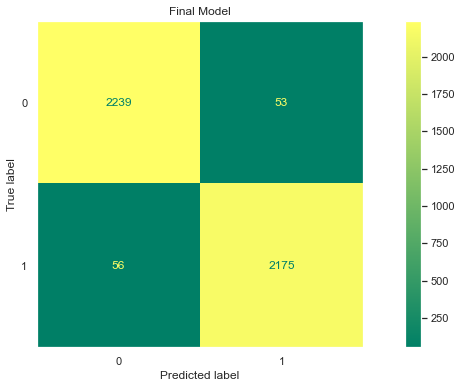

In [134]:
fix, ax = plt.subplots(figsize=(15, 6))

ax.set_title("Final Model")
plot_confusion_matrix(dt_final_sel, X_test_sel, y_test_sel, ax=ax, cmap="summer");
plt.grid(False)